## <center>变分自编码 & 条件变分自编码</center>

### 1 什么是变分自编码

变分自编码器,不是学习样本的特征,<font color='red'>而是学习样本的规律.</font> 这样训练出来的自编码器不单具有重构功能,还具有仿照功能.

变分自编码,<font color='red'>其实就是在编码的过程中改变了样本的分布 ("变分" 可以理解为改变样本分布). </font>前面所说的 "学习样本的规律",具体指的就是学习样本的分布,假设我们知道样本的分布函数,就可以从这个函数中随便取一个样本,然后进行网络解码层前向传导,这样就可以生成一个新样本.

为了得到这个样本的分布函数,模型训练的目的将不再是样本本身,而是通过加一个约束项,将网络生成一个服从于高斯分布的数据集,这样按照高斯分布里的均值和方差规则就可以任意取相关的数据,然后通过解码层还原成样本.

### 2 使用变分自编码器模型生成 MNIST 数据

#### 2.1、定义占位符
本例建立的网络与之前略有不同,编码器为两个全连接层.
+ (1)第一个全连接层由784个维度的输入到256个维度输出. 
+ (2)第二全连接层并列连接了两个输出网络(mean 与 lg_var),每个网络有2个维度的输出.

然后将两个输出通过一个公式计算,输入到一个以2个节点开始的解码部分,接着后面为两个全连接层的解码器:
+ (1)第一个解码器输出256维
+ (2)第二个解码器输出784维
<center><img src="./img/16/2.png"/></center>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data/mnist/")

Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz


In [2]:
# 定义输入维度
n_input = 784
# 定义L1层隐含维度
n_hidden_1 = 256
# 定义L2层隐含维度
n_hidden_2 = 2

x = tf.placeholder(dtype=tf.float32,shape=[None,n_input])
# zinput 是个占位符,要通过它输入分布数据,用来生成模拟样本数据.
zinput = tf.placeholder(dtype=tf.float32,shape=[None,n_hidden_2])

#### 2.2 定义学习参数

In [3]:
weights = {
    'w1': tf.Variable(tf.truncated_normal(shape=[n_input,n_hidden_1],stddev=0.001)),
    'b1': tf.Variable(tf.zeros(shape=[n_hidden_1])),
    'mean_w1': tf.Variable(tf.truncated_normal(shape=[n_hidden_1,n_hidden_2],stddev=0.001)),
    'log_sigma_w1':tf.Variable(tf.truncated_normal(shape=[n_hidden_1,n_hidden_2],stddev=0.001)),
    'mean_b1': tf.Variable(tf.zeros(shape=[n_hidden_2])),
    'log_sigma_b1': tf.Variable(tf.zeros(shape=[n_hidden_2])),
    'w2': tf.Variable(tf.truncated_normal(shape=[n_hidden_2,n_hidden_1],stddev=0.001)),
    'b2': tf.Variable(tf.zeros(shape=[n_hidden_1])),
    'w3': tf.Variable(tf.Variable(tf.truncated_normal(shape=[n_hidden_1,n_input],stddev=0.001))),
    'b3': tf.Variable(tf.zeros(shape=[n_input]))
}

<font color="red">注意:</font><br/>
这里初始化 $w$ 的权重与以往不同, 使用了很小的值(方差为 0.001 的 truncated_normal). 这里设置得非常小心, 由于在算 KL 散度时, 计算的是与标准高斯分布的距离, 如果网络初始生成的模型均值方差都很大, 那么与标准高斯分布的距离就会非常大, 这样会导致模型训练不出来,生成 NAN 的情况.

#### 2.3 定义网络结构
在变分编码器部分, 定义了两个独立的层, 让他们代表均值和方差, 并将他们所代表的数据集向着标准高斯分布数据集靠近 ( 也就是原始数据是样本,高斯分布数据是标签 ) , 然后可以使用 KL 散度公式, 来计算它所代表的集合与标准的高斯分布集合 ( 均值是 0, 方差是 1 的正态分布 ) 间的距离, 将这个距离当成误差, 让它最小化从而优化网络.

这里的方差节点不是真正意义的方差, 而是取了 $log$ 之后的, 所以会有 $tf.exp(z\_log\_sigma\_sq)$ 的变换, 是取得方差的值,再通过 $tf.sqrt$ 将其开平方得到标准差. 用符合标准正态分布的一个数乘以标准差加上均值, 使这个数成为符合 ( $z\_mean$, $sigma$ ) 数据分布集合里的一个点 ( $z\_mean$ 是指网络生成均值, $sigma$ 是指网络生成的 $z\_log\_sigma\_sq$ 变换后的值) .

In [4]:
h1 = tf.nn.relu(tf.add(tf.matmul(x,weights['w1']),weights['b1']))
z_mean = tf.add(tf.matmul(h1,weights['mean_w1']),weights['mean_b1'])
z_log_sigma_sq = tf.add(tf.matmul(h1,weights['log_sigma_w1']),weights['log_sigma_b1'])

# 高斯分布样本
eps = tf.random_normal(tf.stack([tf.shape(h1)[0],n_hidden_2]),mean=0,stddev=1,dtype=tf.float32)
z = tf.add(z_mean,tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)),eps))
h2 = tf.nn.relu(tf.matmul(z,weights['w2'])+weights['b2'])
reconstruction = tf.matmul(h2,weights['w3'])+weights['b3']

h2out = tf.nn.relu( tf.matmul(zinput, weights['w2'])+weights['b2'])
reconstructionout = tf.matmul(h2out,weights['w3'])+weights['b3']

得到了符合原数据集熵的一个具体点 $z$ 之后, 就可以通过神经网络将这个点 $z$ 还原成原始数据 reconstruction 了. 解码部分和编码部分一样, 参考编码的网络还原回去.

#### 2.4 构建模型的反向传播

In [5]:
# 计算重建 loss
reconstr_loss = 0.5*tf.reduce_sum(tf.pow(tf.subtract(reconstruction,x),2.0))
latent_loss = -0.5 * tf.reduce_sum(1+z_log_sigma_sq-tf.square(z_mean)-tf.exp(z_log_sigma_sq),axis=1)
cost = tf.reduce_mean(reconstr_loss+latent_loss)
optimizer = tf.train.AdamOptimizer(learning_rate= 0.001).minimize(cost)

上面代码描述了网络的两个优化方向:
+ (1) 一个是比较生成的数据分布与标准高斯分布的距离, 这里使用 KL 散度公式计算, 具体参考 $latent\_loss$ .
+ (2) 另一个是计算生成数据与原始数据间的损失, 这里用的是平方差, 也可以使用交叉熵.

最后将这两种损失放在一起, 通过 Adam 的随机梯度下降算法优化. 

#### 2.5 模型训练

epoch: 0001 cost= 2793.242675781
epoch: 0004 cost= 2492.434082031
epoch: 0007 cost= 2316.468261719
epoch: 0010 cost= 2192.825927734
epoch: 0013 cost= 2274.838623047
epoch: 0016 cost= 2298.745849609
epoch: 0019 cost= 2012.172119141
epoch: 0022 cost= 1928.126464844
epoch: 0025 cost= 2202.575439453
epoch: 0028 cost= 2071.797851562
epoch: 0031 cost= 2100.811279297
epoch: 0034 cost= 1986.727783203
epoch: 0037 cost= 2054.998535156
epoch: 0040 cost= 2056.676269531
epoch: 0043 cost= 2007.279418945
epoch: 0046 cost= 1936.554931641
epoch: 0049 cost= 1999.638427734
result:  160028.34


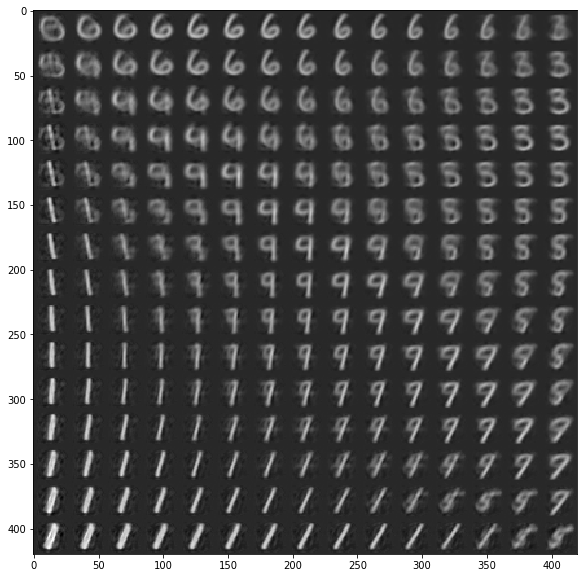

In [6]:
training_epochs = 50
batch_size = 128
display_step = 3

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(training_epochs):
        avg_cost = 0.0
        total_batch = int(mnist.train.num_examples/batch_size)
        # 遍历全部数据
        for i in range(total_batch):
            batch_xs,batch_ys = mnist.train.next_batch(batch_size)
            _,c = sess.run([optimizer,cost],feed_dict={x:batch_xs})
        if epoch % display_step == 0:
            print("epoch:","%04d"%(epoch+1),"cost=","{:.9f}".format(c))
    print("result: ", cost.eval({x:mnist.test.images}))
    
    n = 15 # 15*15 的 figure
    digit_size = 28
    figure = np.zeros((digit_size*n,digit_size*n))
    grid_x = norm.ppf(np.linspace(0.05,0.95,n))
    grid_y = norm.ppf(np.linspace(0.05,0.95,n))
    
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi,yi]])
            x_decoded = sess.run(reconstructionout,feed_dict={zinput:z_sample})
            digit = x_decoded[0].reshape(digit_size,digit_size)
            figure[i*digit_size:(i+1)*digit_size,j*digit_size:(j+1)*digit_size] = digit
    plt.figure(figsize=(10,10))
    plt.imshow(figure,cmap="Greys_r")
    plt.show()

#### 2.6 生成模拟数据
为了证实模型学到了数据分布的情况, 这里在高斯分布抽样中取一些点, 将其映射到模型中的 $z$, 然后通过解码部分还原真实图片.

### 3 条件变分自编码

#### 3.1 什么是条件变分自编码
变分自编码存在的一个问题是, 虽然可以生成一个样本, 但是只能输出与输入图片相同类别的样本. 虽然也可以随机从符合模型生成的高斯分布中取数据来还原样本, 但是这样的话我们并不知道生成的样本属于哪个类别. 条件变分自编码则可以解决这个问题, 让网络按指定的类别生成样本.

在变分自编码的基础上, 再去理解条件变分自编码会很容易. 主要的改动是, 在训练和测试时加入一个 one-hot 向量, 用于表示标签向量. 其实,就是给变分自编码网络加入一个条件, 让网络学习图片分布时加入了标签因素, 这样可以按照标签的数值生成指定的图片.

#### 3.2 使用标签指导变分自编码网络生成 MNIST 数据
在编码阶段需要在输入端添加标签对应的特征, 在解码阶段同样也需要将标签加入输入, 这样, 在训练过程中, 解码的结果不断靠近原来输入样本. 最终得到的模型将会把输入的标签特征当成 MNIST 数据的一部分, 从而实现通过标签生成 MNIST 数据. 模型的具体框架如图:
<center><img src="./img/16/1.png"/></center>